In [63]:
from importlib import reload  # Python 3.4+

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from timeit import default_timer as timer
import itertools
from scipy.stats import sem

### Generating Data
Parameters:
- $p$, number of variables.
- $s$, number of arcs.
- $|s|$, size of autoregressive coefficients.
- $T$, number of timesteps.

In [2]:
import math

In [10]:
def gen_W(p, s, low, high, acyclic = True, regress = 0, seed = 12345):
    np.random.seed(seed)
    
    W = np.zeros((p, p))
    # randomly generate an acyclic coefficient matrix, fill diagonals
    
    if acyclic:
        # generate s off-diagonal elements uniform between +- low, high
        arcs = np.array([0.0] * (p ** 2 - s - p) + [1.0] * s)
        arcs[arcs > 0] = (2 * np.random.randint(0, 2, size=(s)) - 1) * np.random.uniform(low, high, s)
        np.random.shuffle(arcs)
    
        W[np.tril_indices(p, - 1)] = arcs[:int(len(arcs) / 2)]
        W[np.triu_indices(p, + 1)] = arcs[int(len(arcs) / 2):]

    #else:
        # generate acyclicly s off-diagonal elements uniform between +- low high
    
    
    # fill diagonal based on strength
    for i in range(p):
        W[i][i] = 0.5 + 0.2 * regress
        
    return W

gen_W(5, 5, 0.5, 0.5)

array([[ 0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0. ,  0. ,  0.5],
       [-0.5, -0.5,  0.5,  0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0.5,  0. ],
       [ 0. ,  0. ,  0.5,  0. ,  0.5]])

is cyclic: True
stationary: 1.07
is cyclic: True
stationary: 1.012
is cyclic: True
stationary: 0.966
[[ 0.45  0.    0.   ...  0.    0.45  0.  ]
 [ 0.    0.45 -0.45 ...  0.    0.    0.  ]
 [ 0.   -0.45  0.45 ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  0.45  0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.45  0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.45]]


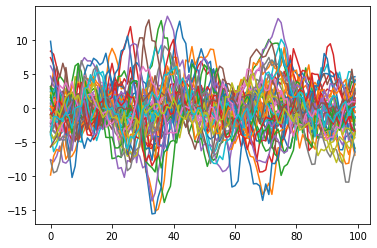

In [53]:
def gen_W(p, s, low, high, acyclic = True, regress = 0, seed = 12345):
    np.random.seed(seed)
    
    W = np.zeros((p, p))
    # randomly generate an acyclic coefficient matrix, fill diagonals
    
    if acyclic:
        # generate s off-diagonal elements uniform between +- low, high
        arcs = np.array([0.0] * (p ** 2 - s - p) + [1.0] * s)
        arcs[arcs > 0] = (2 * np.random.randint(0, 2, size=(s)) - 1) * np.random.uniform(low, high, s)
        np.random.shuffle(arcs)
    
        W[np.tril_indices(p, - 1)] = arcs[:int(len(arcs) / 2)]
        W[np.triu_indices(p, + 1)] = arcs[int(len(arcs) / 2):]

    #else:
        # generate acyclicly s off-diagonal elements uniform between +- low high
    
    
    # fill diagonal based on strength
    for i in range(p):
        W[i][i] = 0.45 + 0.2 * regress
    
    
    return W

def cov_X(W):
    
    p = np.shape(W)[0]
    # covariance matrix
    return (np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)) @ np.identity(p).reshape(p ** 2)).reshape((p, p))

def expected_cost_var(W_true, W_est):
    
    # covariance matrix
    covariance_matrix = np.identity(p) + np.matmul((W_true - W_est).T, np.matmul(cov_X(W_true), (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

def gen_var(W, T, seed = 123245):
    np.random.seed(seed)
    
    # get number of variables
    p = np.shape(W)[0]
    
    # Initialize series
    X = np.array(np.zeros((T, p)))

    # noise 
    noise = np.vstack((np.random.multivariate_normal(np.zeros(p), cov_X(W), 1), np.random.multivariate_normal(np.zeros(p), np.identity(p), T - 1)))
    X[0] = noise[0]
    
    # Generate series
    for t in range(1, T):
        # First the randomness
        X[t] = X[t - 1] @ W + noise[t]
    
    # Return series
    return X

def gen_data(p, s, T, low = 0.45, high = 0.45, regress = 0, seed = 12345):
    q = 0
    # generate matrix
    W = gen_W(p, min(2 * p, int(p * (p - 1) / 2)), low, high, regress = regress, seed = seed + q)
    
    print("is cyclic:", not h.is_dag(W))
    print("stationary:", round(max(np.abs(np.linalg.eig(W)[0])), 3))
    
    while (h.is_dag(W) or max(np.abs(np.linalg.eig(W)[0])) > 0.99):
        q += 1
        W = gen_W(p, min(2 * p, int(p * (p - 1) / 2)), low, high, regress = regress, seed = seed + 12345 * q)
        
        print("is cyclic:", not h.is_dag(W))
        print("stationary:", round(max(np.abs(np.linalg.eig(W)[0])), 3))
        
    # generate VAR(1) model in stationary distribution
    X = gen_var(W, T, seed = seed)
    
    return W, X, 

W, X = gen_data(p = 50, s = 50, T = 100, regress = 0, seed = 3)
print(W)
plt.plot(X);

### Generate the datasets

In [140]:
from tqdm import tqdm
datasets = []

p_range = [5, 10, 15,25, 50]

for p in tqdm(p_range):
    datasets_p = []
    
    for i in range(10):
        W, X = gen_data(p, 0, 1000, seed = i)
        datasets_p.append((W, X))
        # plt.plot(X)
        # plt.show()
    datasets.append(datasets_p)

 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  8.62it/s]

is cyclic: True
stationary: 1.086
is cyclic: True
stationary: 0.803
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 0.779
is cyclic: True
stationary: 1.017
is cyclic: True
stationary: 0.971
is cyclic: True
stationary: 1.178
is cyclic: True
stationary: 0.86
is cyclic: True
stationary: 1.006
is cyclic: True
stationary: 1.078
is cyclic: True
stationary: 1.35
is cyclic: True
stationary: 0.862
is cyclic: True
stationary: 1.017
is cyclic: True
stationary: 0.942
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 0.927
is cyclic: True
stationary: 1.128
is cyclic: True
stationary: 1.11
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 1.001
is cyclic: True
stationary: 1.111
is cyclic: True
stationary: 0.972
is cyclic: True
stationary: 0.779
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 0.905
is cyclic: True
stationary: 0.997
is cyclic: True
stationary: 1.03
is cyclic: True
stationary: 1.046
is cyclic: True
stationary: 

 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00,  3.03it/s]

 True
stationary: 0.9
is cyclic: True
stationary: 1.086
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 0.965
is cyclic: True
stationary: 0.942
is cyclic: True
stationary: 0.963
is cyclic: True
stationary: 1.094
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 1.025
is cyclic: True
stationary: 1.226
is cyclic: True
stationary: 0.96
is cyclic: True
stationary: 0.967
is cyclic: True
stationary: 0.995
is cyclic: True
stationary: 1.205
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 1.016
is cyclic: True
stationary: 0.967
is cyclic: True
stationary: 0.903
is cyclic: True
stationary: 0.985
is cyclic: True
stationary: 1.127
is cyclic: True
stationary: 1.074
is cyclic: True
stationary: 1.102
is cyclic: True
stationary: 1.035
is cyclic: True
stationary: 0.959
is cyclic: True
stationary: 0.911


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:01<00:01,  1.39it/s]

is cyclic: True
stationary: 0.938
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 0.999
is cyclic: True
stationary: 1.076
is cyclic: True
stationary: 1.05
is cyclic: True
stationary: 0.936
is cyclic: True
stationary: 0.989
is cyclic: True
stationary: 0.942
is cyclic: True
stationary: 0.935
is cyclic: True
stationary: 0.955
is cyclic: True
stationary: 1.094
is cyclic: True
stationary: 1.113
is cyclic: True
stationary: 0.973
is cyclic: True
stationary: 1.068
is cyclic: True
stationary: 0.9
is cyclic: True
stationary: 0.9


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:05<00:01,  1.87s/it]

is cyclic: True
stationary: 1.09
is cyclic: True
stationary: 1.117
is cyclic: True
stationary: 1.005
is cyclic: True
stationary: 1.056
is cyclic: True
stationary: 1.007
is cyclic: True
stationary: 1.058
is cyclic: True
stationary: 1.004
is cyclic: True
stationary: 1.035
is cyclic: True
stationary: 0.995
is cyclic: True
stationary: 0.994
is cyclic: True
stationary: 0.986
is cyclic: True
stationary: 1.022
is cyclic: True
stationary: 1.022
is cyclic: True
stationary: 1.128
is cyclic: True
stationary: 0.941
is cyclic: True
stationary: 1.059
is cyclic: True
stationary: 1.014
is cyclic: True
stationary: 0.939
is cyclic: True
stationary: 1.07
is cyclic: True
stationary: 1.012
is cyclic: True
stationary: 0.966
is cyclic: True
stationary: 1.081
is cyclic: True
stationary: 1.033
is cyclic: True
stationary: 1.021
is cyclic: True
stationary: 1.018
is cyclic: True
stationary: 0.953
is cyclic: True
stationary: 1.027
is cyclic: True
stationary: 1.089
is cyclic: True
stationary: 0.959
is cyclic: True


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.26s/it]


In [55]:
def con_OLS(X, B):
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F[:-1].T @ X_F[:-1]) @ X_F[:-1].T @ X[1:, i]
        
    return W

In [56]:
def evaluate(results, X, W_true, W_m, method, epsilon = 0.30, verbose = True):
    # get mse
    _, _, _, _, shd_1, mse, _ = h.score(X, W_m, W_true, printing = False)
    results[method]['mse'].append(mse)

    
    # do thresholding to get shd
    W_m[np.abs(W_m) <= epsilon] = 0

    _, _, _, _, shd, _, _ = h.score(X, W_m, W_true, printing = False)
    results[method]['shd'].append(shd)
    
    # do reestimated to get expected mean squared error
    emse = expected_cost_var(W_true, con_OLS(X, W_m != 0))
    results[method]['emse'].append(emse)
    
    if verbose:
        print(method)
        print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")
        
    return results

In [59]:
# mean squared, true risk, and shd per method
results = {
#     "exh": {"mse": [], "emse": [], "shd": []},
#     "rw_1": {"mse": [], "emse": [], "shd": []},
    "rw_2": {"mse": [], "emse": [], "shd": []},
    "mcmc_r": {"mse": [], "emse": [], "shd": []},
#     "mcmc_t": {"mse": [], "emse": [], "shd": []},
#     "mcmc_s": {"mse": [], "emse": [], "shd": []},
    "mcmc_g": {"mse": [], "emse": [], "shd": []},
    "notears": {"mse": [], "emse": [], "shd": []},
    "daglasso": {"mse": [], "emse": [], "shd": []},
    "dagomp": {"mse": [], "emse": [], "shd": []},
    "dagols": {"mse": [], "emse": [], "shd": []},
}


In [141]:
import time
iters = 1000

old_time = time.time()
# for each dataset
for dataset in datasets:
    for W, X in dataset:
        # for each method:
        T, p = np.shape(X)
        m.T, m.p = T, p
        
        
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
    
    # 1: Exhaustive:
#     if p <= 8:
#         W_exh = m.exh(X[:-1], X[1:])
        
#         # 2.1: Random Walk 1, need regularizing
#         W_rw_1 = m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1]
#         results = evaluate(results, X, W, W_rw_1, "rw_1")
    
    # 2.2: Random Walk 2
        W_rw_2 = m.rw_2(X[:-1], X[1:], np.identity(p), iters)[1]
        results = evaluate(results, X, W, W_rw_2, "rw_2")
    
    # 3.1: MCMC 1
        W_mcmc_1 = m.mcmc_1(X[:-1], X[1:], iters, np.identity(p))[1]
        results = evaluate(results, X, W, W_mcmc_1, "mcmc_r")
    
#     # 3.2: MCMC 2
#     W_mcmc_2 = m.mcmc_2(X[:-1], X[1:], iters, np.identity(p))[1]
#     results = evaluate(results, X, W, W_mcmc_2, "mcmc_t")
    
#     # 3.3: MCMC 3
#     W_mcmc_3 = m.mcmc_3(X[:-1], X[1:], iters, np.identity(p))[1]
#     results = evaluate(results, X, W, W_mcmc_3, "mcmc_s")
    
    # 3.4: MCMC 4
        W_mcmc_4 = m.mcmc_4(X[:-1], X[1:], iters, np.identity(p))[1]
        results = evaluate(results, X, W, W_mcmc_4, "mcmc_g")
    
    # 4: NO TEARS, NEED TO REGULARIZE using bootstrap.
        W_notears, _ = m.notears_2(X, lambda1 = 0.0)
        results = evaluate(results, X, W, W_notears, "notears")
    
        # 5: LASSO-DAG, NEED TO REGULARIZE using bootstrap.
        W_lassodag, alpha = m._LASSO_LINGNAM(X, step_size = 0.25)
        print("DAG-LASSO alpha:", alpha)
        results = evaluate(results, X, W, W_lassodag, "daglasso")
    
    # 6: DAG-OMP, NEED TO REGULARIZE using cross-validation.
        W_omp, _ = m._K_OMP(X[:-1], X[1:], F = [], normalize = True)
        results = evaluate(results, X, W, W_omp, "dagomp")
    
# #         # 7: DAG-LASSO, NEED TO REGULARIZE using bootstrap.
        W_olsdag = con_OLS(X, B_V_LINGNAM_OLS_Q(X) != 0)
        results = evaluate(results, X, W, W_olsdag, "dagols")
        
print(f"Done! Took {time.time() - old_time} seconds.")

  7%|█████▌                                                                         | 71/1000 [00:00<00:01, 709.99it/s]

rw_2
SHD: 4, Empirial Risk: 5.983, True Risk: 6.206.


  7%|█████▌                                                                         | 71/1000 [00:00<00:01, 709.99it/s]

mcmc_r
SHD: 4, Empirial Risk: 5.983, True Risk: 6.206.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 685.40it/s]


mcmc_g
SHD: 4, Empirial Risk: 5.984, True Risk: 6.206.


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

notears
SHD: 4, Empirial Risk: 5.984, True Risk: 6.206.
DAG-LASSO alpha: 1.25
daglasso
SHD: 15, Empirial Risk: 10.35, True Risk: 14.178.
dagomp
SHD: 4, Empirial Risk: 6.327, True Risk: 6.552.
dagols
SHD: 5, Empirial Risk: 6.532, True Risk: 6.768.


  7%|█████▌                                                                         | 71/1000 [00:00<00:01, 709.99it/s]

rw_2
SHD: 3, Empirial Risk: 6.594, True Risk: 6.615.


  7%|█████▊                                                                         | 74/1000 [00:00<00:01, 739.97it/s]

mcmc_r
SHD: 3, Empirial Risk: 6.594, True Risk: 6.615.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 701.75it/s]


mcmc_g
SHD: 3, Empirial Risk: 6.594, True Risk: 6.615.
notears
SHD: 3, Empirial Risk: 6.594, True Risk: 6.615.
DAG-LASSO alpha: 3.0
daglasso
SHD: 13, Empirial Risk: 18.855, True Risk: 17.863.
dagomp
SHD: 3, Empirial Risk: 6.594, True Risk: 6.615.
dagols

  6%|████▋                                                                          | 60/1000 [00:00<00:01, 594.08it/s]


SHD: 4, Empirial Risk: 7.721, True Risk: 7.657.


  3%|██▌                                                                            | 32/1000 [00:00<00:03, 316.84it/s]

rw_2
SHD: 2, Empirial Risk: 5.773, True Risk: 5.838.


  5%|███▊                                                                           | 48/1000 [00:00<00:02, 475.23it/s]

mcmc_r
SHD: 2, Empirial Risk: 5.773, True Risk: 5.838.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 551.26it/s]


mcmc_g
SHD: 2, Empirial Risk: 5.773, True Risk: 5.838.
notears
SHD: 2, Empirial Risk: 5.773, True Risk: 5.838.
DAG-LASSO alpha: 2.5
daglasso
SHD: 15, Empirial Risk: 15.384, True Risk: 16.877.
dagomp

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
  5%|███▊                                                                           | 49/1000 [00:00<00:01, 485.13it/s]


SHD: 2, Empirial Risk: 5.773, True Risk: 5.838.
dagols
SHD: 2, Empirial Risk: 5.773, True Risk: 5.838.


  5%|███▊                                                                           | 49/1000 [00:00<00:01, 485.17it/s]

rw_2
SHD: 6, Empirial Risk: 7.151, True Risk: 7.348.


  4%|███▍                                                                           | 44/1000 [00:00<00:02, 435.64it/s]

mcmc_r
SHD: 6, Empirial Risk: 7.151, True Risk: 7.348.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.78it/s]


mcmc_g
SHD: 5, Empirial Risk: 7.444, True Risk: 7.473.
notears
SHD: 6, Empirial Risk: 7.151, True Risk: 7.348.
DAG-LASSO alpha:

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

 5.25
daglasso
SHD: 13, Empirial Risk: 22.211, True Risk: 31.509.
dagomp
SHD: 8, Empirial Risk: 7.397, True Risk: 7.704.
dagols
SHD: 6, Empirial Risk: 8.447, True Risk: 9.211.


  6%|████▌                                                                          | 58/1000 [00:00<00:01, 579.99it/s]

rw_2
SHD: 4, Empirial Risk: 6.451, True Risk: 6.82.


  5%|███▊                                                                           | 49/1000 [00:00<00:01, 480.41it/s]

mcmc_r
SHD: 4, Empirial Risk: 6.451, True Risk: 6.82.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 537.05it/s]


mcmc_g
SHD: 5, Empirial Risk: 6.739, True Risk: 7.041.


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

notears
SHD: 4, Empirial Risk: 6.719, True Risk: 7.093.
DAG-LASSO alpha: 1.5
daglasso
SHD: 15, Empirial Risk: 12.23, True Risk: 17.799.
dagomp
SHD: 4, Empirial Risk: 6.719, True Risk: 7.093.
dagols
SHD: 5, Empirial Risk: 7.018, True Risk: 7.434.


  7%|█████▌                                                                         | 70/1000 [00:00<00:01, 693.07it/s]

rw_2
SHD: 2, Empirial Risk: 6.527, True Risk: 6.395.


  7%|█████▌                                                                         | 70/1000 [00:00<00:01, 693.07it/s]

mcmc_r
SHD: 2, Empirial Risk: 6.527, True Risk: 6.395.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 664.89it/s]


mcmc_g
SHD: 4, Empirial Risk: 6.882, True Risk: 7.044.


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

notears
SHD: 2, Empirial Risk: 6.527, True Risk: 6.395.
DAG-LASSO alpha: 1.75
daglasso
SHD: 15, Empirial Risk: 12.773, True Risk: 17.043.
dagomp
SHD: 6, Empirial Risk: 7.271, True Risk: 7.145.
dagols
SHD: 5, Empirial Risk: 7.443, True Risk: 7.559.


  8%|██████▎                                                                        | 80/1000 [00:00<00:01, 799.99it/s]

rw_2
SHD: 5, Empirial Risk: 7.124, True Risk: 7.386.


  8%|██████▌                                                                        | 83/1000 [00:00<00:01, 813.75it/s]

mcmc_r
SHD: 5, Empirial Risk: 7.124, True Risk: 7.386.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 769.82it/s]


mcmc_g
SHD: 5, Empirial Risk: 7.124, True Risk: 7.386.
notears
SHD: 5, Empirial Risk: 7.129, True Risk: 7.598.
DAG-LASSO alpha: 4.5
daglasso
SHD: 14, Empirial Risk: 24.563, True Risk: 25.148.
dagomp
SHD: 5, Empirial Risk: 8.111, True Risk: 8.517.
dagols

  8%|██████▋                                                                        | 85/1000 [00:00<00:01, 841.85it/s]


SHD: 8, Empirial Risk: 8.518, True Risk: 9.278.


  7%|█████▌                                                                         | 70/1000 [00:00<00:01, 693.08it/s]

rw_2
SHD: 3, Empirial Risk: 6.475, True Risk: 6.786.


  8%|██████▌                                                                        | 83/1000 [00:00<00:01, 821.79it/s]

mcmc_r
SHD: 3, Empirial Risk: 6.475, True Risk: 6.786.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 788.64it/s]


mcmc_g
SHD: 3, Empirial Risk: 6.475, True Risk: 6.786.


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

notears
SHD: 3, Empirial Risk: 6.475, True Risk: 6.786.
DAG-LASSO alpha: 3.0
daglasso
SHD: 15, Empirial Risk: 19.696, True Risk: 22.383.
dagomp
SHD: 3, Empirial Risk: 6.781, True Risk: 7.12.
dagols
SHD: 5, Empirial Risk: 7.101, True Risk: 7.514.


  8%|██████▍                                                                        | 81/1000 [00:00<00:01, 809.98it/s]

rw_2
SHD: 2, Empirial Risk: 5.638, True Risk: 5.758.


  8%|██████▎                                                                        | 80/1000 [00:00<00:01, 799.98it/s]

mcmc_r
SHD: 2, Empirial Risk: 5.638, True Risk: 5.758.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 778.81it/s]


mcmc_g
SHD: 2, Empirial Risk: 5.638, True Risk: 5.758.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

notears
SHD: 2, Empirial Risk: 5.638, True Risk: 5.758.
DAG-LASSO alpha: 3.0
daglasso
SHD: 13, Empirial Risk: 14.516, True Risk: 13.205.
dagomp
SHD: 2, Empirial Risk: 5.638, True Risk: 5.758.
dagols
SHD: 2, Empirial Risk: 5.638, True Risk: 5.758.


  6%|████▉                                                                          | 62/1000 [00:00<00:01, 613.84it/s]

rw_2
SHD: 2, Empirial Risk: 7.151, True Risk: 6.915.


  8%|██████▍                                                                        | 82/1000 [00:00<00:01, 811.89it/s]

mcmc_r
SHD: 2, Empirial Risk: 7.151, True Risk: 6.915.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 759.29it/s]


mcmc_g
SHD: 5, Empirial Risk: 7.78, True Risk: 7.35.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

notears
SHD: 2, Empirial Risk: 7.151, True Risk: 6.915.
DAG-LASSO alpha: 2.5
daglasso
SHD: 14, Empirial Risk: 17.077, True Risk: 20.345.
dagomp
SHD: 6, Empirial Risk: 8.64, True Risk: 8.508.
dagols
SHD: 4, Empirial Risk: 8.208, True Risk: 7.883.


  4%|██▊                                                                            | 36/1000 [00:00<00:02, 356.43it/s]

rw_2
SHD: 6, Empirial Risk: 11.655, True Risk: 12.22.


  3%|██▋                                                                            | 34/1000 [00:00<00:02, 336.64it/s]

mcmc_r
SHD: 4, Empirial Risk: 11.897, True Risk: 12.318.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.81it/s]


mcmc_g
SHD: 3, Empirial Risk: 11.44, True Risk: 11.989.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 4, Empirial Risk: 11.453, True Risk: 11.939.
DAG-LASSO alpha: 2.75
daglasso
SHD: 28, Empirial Risk: 27.076, True Risk: 34.316.
dagomp
SHD: 6, Empirial Risk: 11.634, True Risk: 12.22.


  4%|███                                                                            | 38/1000 [00:00<00:02, 376.24it/s]

dagols
SHD: 6, Empirial Risk: 11.788, True Risk: 12.22.


  3%|██▋                                                                            | 34/1000 [00:00<00:02, 339.99it/s]

rw_2
SHD: 8, Empirial Risk: 14.634, True Risk: 17.1.


  4%|██▊                                                                            | 36/1000 [00:00<00:02, 349.51it/s]

mcmc_r
SHD: 8, Empirial Risk: 14.692, True Risk: 17.37.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.78it/s]


mcmc_g
SHD: 7, Empirial Risk: 13.897, True Risk: 14.705.
notears
SHD: 7, Empirial Risk: 14.444, True Risk: 16.75.
DAG-LASSO alpha: 13.0
daglasso
SHD: 30, Empirial Risk: 79.751, True Risk: 84.681.
dagomp
SHD: 8, Empirial Risk: 15.374, True Risk: 15.879.


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
  4%|███                                                                            | 38/1000 [00:00<00:02, 372.54it/s]

dagols
SHD: 8, Empirial Risk: 16.638, True Risk: 17.132.


  4%|██▊                                                                            | 36/1000 [00:00<00:02, 356.44it/s]

rw_2
SHD: 3, Empirial Risk: 11.899, True Risk: 11.955.


  4%|██▉                                                                            | 37/1000 [00:00<00:02, 362.75it/s]

mcmc_r
SHD: 3, Empirial Risk: 11.938, True Risk: 12.183.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.26it/s]


mcmc_g
SHD: 4, Empirial Risk: 11.813, True Risk: 12.202.
notears
SHD: 2, Empirial Risk: 11.392, True Risk: 11.536.
DAG-LASSO alpha: 5.0
daglasso
SHD: 30, Empirial Risk: 34.925, True Risk: 38.795.
dagomp
SHD: 3, Empirial Risk: 11.564, True Risk: 11.681.


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
  4%|██▊                                                                            | 35/1000 [00:00<00:02, 339.80it/s]

dagols
SHD: 2, Empirial Risk: 12.123, True Risk: 12.254.


  4%|██▊                                                                            | 36/1000 [00:00<00:02, 356.43it/s]

rw_2
SHD: 6, Empirial Risk: 11.979, True Risk: 12.356.


  4%|██▉                                                                            | 37/1000 [00:00<00:02, 366.33it/s]

mcmc_r
SHD: 5, Empirial Risk: 11.862, True Risk: 12.487.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.41it/s]


mcmc_g
SHD: 6, Empirial Risk: 11.774, True Risk: 12.238.


..\notears\notears\notears\linear.py:73: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
..\notears\notears\notears\linear.py:74: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h
..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 5, Empirial Risk: 11.457, True Risk: 11.818.
DAG-LASSO alpha: 1.75
daglasso
SHD: 27, Empirial Risk: 24.737, True Risk: 25.041.
dagomp
SHD: 5, Empirial Risk: 11.457, True Risk: 11.872.


  3%|██▋                                                                            | 34/1000 [00:00<00:02, 333.34it/s]

dagols
SHD: 5, Empirial Risk: 11.516, True Risk: 11.846.


  4%|██▉                                                                            | 37/1000 [00:00<00:02, 366.33it/s]

rw_2
SHD: 6, Empirial Risk: 12.572, True Risk: 13.352.


  4%|██▊                                                                            | 36/1000 [00:00<00:02, 356.45it/s]

mcmc_r
SHD: 5, Empirial Risk: 12.834, True Risk: 13.35.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.41it/s]


mcmc_g
SHD: 8, Empirial Risk: 12.749, True Risk: 13.675.
notears
SHD: 6, Empirial Risk: 12.264, True Risk: 12.872.
DAG-LASSO alpha: 3.5
daglasso
SHD: 29, Empirial Risk: 33.928, True Risk: 38.193.
dagomp
SHD: 8, Empirial Risk: 12.888, True Risk: 13.432.


  4%|███                                                                            | 38/1000 [00:00<00:02, 368.94it/s]

dagols
SHD: 8, Empirial Risk: 13.699, True Risk: 14.279.


  4%|██▉                                                                            | 37/1000 [00:00<00:02, 370.00it/s]

rw_2
SHD: 3, Empirial Risk: 11.676, True Risk: 12.016.


  7%|█████▍                                                                         | 69/1000 [00:00<00:02, 337.15it/s]

mcmc_r
SHD: 5, Empirial Risk: 12.03, True Risk: 12.154.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.22it/s]


mcmc_g
SHD: 5, Empirial Risk: 12.003, True Risk: 12.154.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 5, Empirial Risk: 11.831, True Risk: 11.939.
DAG-LASSO alpha: 1.75
daglasso
SHD: 28, Empirial Risk: 23.841, True Risk: 30.197.
dagomp
SHD: 5, Empirial Risk: 11.873, True Risk: 12.062.


  3%|██▏                                                                            | 27/1000 [00:00<00:03, 259.62it/s]

dagols
SHD: 6, Empirial Risk: 13.327, True Risk: 13.43.


  3%|██▌                                                                            | 33/1000 [00:00<00:02, 329.98it/s]

rw_2
SHD: 5, Empirial Risk: 12.294, True Risk: 12.677.


  3%|██▌                                                                            | 33/1000 [00:00<00:02, 329.99it/s]

mcmc_r
SHD: 5, Empirial Risk: 12.225, True Risk: 12.267.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.16it/s]


mcmc_g
SHD: 4, Empirial Risk: 11.861, True Risk: 12.203.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 4, Empirial Risk: 11.862, True Risk: 12.199.
DAG-LASSO alpha: 2.5
daglasso
SHD: 29, Empirial Risk: 30.396, True Risk: 32.822.
dagomp
SHD: 5, Empirial Risk: 12.024, True Risk: 12.416.


  3%|██                                                                             | 26/1000 [00:00<00:03, 252.42it/s]

dagols
SHD: 7, Empirial Risk: 12.216, True Risk: 12.858.


  3%|██▎                                                                            | 29/1000 [00:00<00:03, 281.55it/s]

rw_2
SHD: 5, Empirial Risk: 12.069, True Risk: 12.628.


  3%|██▌                                                                            | 32/1000 [00:00<00:03, 316.84it/s]

mcmc_r
SHD: 6, Empirial Risk: 12.272, True Risk: 13.019.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.18it/s]


mcmc_g
SHD: 5, Empirial Risk: 11.812, True Risk: 12.426.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 5, Empirial Risk: 11.678, True Risk: 12.484.
DAG-LASSO alpha: 5.25
daglasso
SHD: 26, Empirial Risk: 36.899, True Risk: 36.863.
dagomp
SHD: 4, Empirial Risk: 11.524, True Risk: 12.099.


  3%|██▌                                                                            | 32/1000 [00:00<00:03, 310.68it/s]

dagols
SHD: 7, Empirial Risk: 12.667, True Risk: 13.673.


  3%|██▍                                                                            | 31/1000 [00:00<00:03, 309.99it/s]

rw_2
SHD: 9, Empirial Risk: 14.63, True Risk: 14.635.


  3%|██▌                                                                            | 32/1000 [00:00<00:03, 307.69it/s]

mcmc_r
SHD: 5, Empirial Risk: 14.884, True Risk: 15.657.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.59it/s]


mcmc_g
SHD: 10, Empirial Risk: 15.575, True Risk: 15.783.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 6, Empirial Risk: 14.378, True Risk: 13.955.
DAG-LASSO alpha: 5.25
daglasso
SHD: 27, Empirial Risk: 47.404, True Risk: 48.502.
dagomp
SHD: 13, Empirial Risk: 19.393, True Risk: 18.674.


  3%|██▌                                                                            | 33/1000 [00:00<00:02, 329.98it/s]

dagols
SHD: 10, Empirial Risk: 19.945, True Risk: 19.283.


  4%|██▊                                                                            | 36/1000 [00:00<00:02, 352.94it/s]

rw_2
SHD: 4, Empirial Risk: 12.004, True Risk: 12.056.


  2%|█▉                                                                             | 25/1000 [00:00<00:03, 247.52it/s]

mcmc_r
SHD: 4, Empirial Risk: 12.0, True Risk: 12.056.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 226.34it/s]


mcmc_g
SHD: 4, Empirial Risk: 11.906, True Risk: 12.809.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 5, Empirial Risk: 11.867, True Risk: 12.153.
DAG-LASSO alpha: 3.5
daglasso
SHD: 25, Empirial Risk: 20.768, True Risk: 55.462.
dagomp
SHD: 6, Empirial Risk: 12.235, True Risk: 13.175.


  2%|█▌                                                                             | 20/1000 [00:00<00:05, 194.18it/s]

dagols
SHD: 6, Empirial Risk: 12.932, True Risk: 13.204.


  2%|█▎                                                                             | 17/1000 [00:00<00:06, 163.46it/s]

rw_2
SHD: 7, Empirial Risk: 17.321, True Risk: 18.421.


  2%|█▎                                                                             | 16/1000 [00:00<00:06, 153.84it/s]

mcmc_r
SHD: 7, Empirial Risk: 17.193, True Risk: 17.798.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.28it/s]


mcmc_g
SHD: 3, Empirial Risk: 16.013, True Risk: 16.544.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 4, Empirial Risk: 16.086, True Risk: 16.523.
DAG-LASSO alpha: 7.25
daglasso
SHD: 42, Empirial Risk: 72.226, True Risk: 98.779.
dagomp
SHD: 4, Empirial Risk: 16.078, True Risk: 16.523.


  2%|█▎                                                                             | 17/1000 [00:00<00:05, 166.67it/s]

dagols
SHD: 6, Empirial Risk: 17.327, True Risk: 17.894.


  2%|█▎                                                                             | 17/1000 [00:00<00:06, 161.90it/s]

rw_2
SHD: 6, Empirial Risk: 17.219, True Risk: 17.934.


  2%|█▎                                                                             | 16/1000 [00:00<00:06, 156.87it/s]

mcmc_r
SHD: 7, Empirial Risk: 17.088, True Risk: 17.294.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.90it/s]


mcmc_g
SHD: 3, Empirial Risk: 16.103, True Risk: 16.328.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 3, Empirial Risk: 15.983, True Risk: 16.15.
DAG-LASSO alpha: 3.75
daglasso
SHD: 46, Empirial Risk: 43.257, True Risk: 57.154.
dagomp
SHD: 3, Empirial Risk: 16.018, True Risk: 16.296.


  2%|█▎                                                                             | 16/1000 [00:00<00:06, 160.00it/s]

dagols
SHD: 4, Empirial Risk: 16.524, True Risk: 16.781.


  2%|█▍                                                                             | 18/1000 [00:00<00:05, 174.76it/s]

rw_2
SHD: 12, Empirial Risk: 21.767, True Risk: 22.957.


  2%|█▎                                                                             | 16/1000 [00:00<00:06, 156.87it/s]

mcmc_r
SHD: 13, Empirial Risk: 22.003, True Risk: 23.928.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.56it/s]


mcmc_g
SHD: 8, Empirial Risk: 20.143, True Risk: 20.629.


..\notears\notears\notears\linear.py:73: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
..\notears\notears\notears\linear.py:74: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h
..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 10, Empirial Risk: 21.003, True Risk: 21.925.
DAG-LASSO alpha: 5.75


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


daglasso
SHD: 45, Empirial Risk: 75.069, True Risk: 87.993.
dagomp
SHD: 8, Empirial Risk: 21.046, True Risk: 22.078.


  2%|█▎                                                                             | 17/1000 [00:00<00:05, 166.66it/s]

dagols
SHD: 8, Empirial Risk: 21.2, True Risk: 21.631.


  2%|█▎                                                                             | 17/1000 [00:00<00:06, 163.46it/s]

rw_2
SHD: 12, Empirial Risk: 18.961, True Risk: 20.091.


  2%|█▎                                                                             | 17/1000 [00:00<00:05, 165.05it/s]

mcmc_r
SHD: 12, Empirial Risk: 19.898, True Risk: 21.137.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.61it/s]


mcmc_g
SHD: 8, Empirial Risk: 17.381, True Risk: 18.086.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 7, Empirial Risk: 16.948, True Risk: 17.619.
DAG-LASSO alpha: 3.25
daglasso
SHD: 39, Empirial Risk: 45.246, True Risk: 53.685.
dagomp
SHD: 9, Empirial Risk: 17.594, True Risk: 18.329.


  2%|█▎                                                                             | 17/1000 [00:00<00:06, 161.90it/s]

dagols
SHD: 6, Empirial Risk: 18.567, True Risk: 18.735.


  2%|█▎                                                                             | 16/1000 [00:00<00:06, 155.34it/s]

rw_2
SHD: 9, Empirial Risk: 20.119, True Risk: 20.97.


  2%|█▍                                                                             | 18/1000 [00:00<00:05, 179.99it/s]

mcmc_r
SHD: 15, Empirial Risk: 20.309, True Risk: 21.328.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.36it/s]


mcmc_g
SHD: 8, Empirial Risk: 18.829, True Risk: 20.268.
notears
SHD: 6, Empirial Risk: 18.271, True Risk: 19.784.
DAG-LASSO alpha: 5.5
daglasso
SHD: 40, Empirial Risk: 57.124, True Risk: 67.71.
dagomp
SHD: 7, Empirial Risk: 18.755, True Risk: 19.862.


  2%|█▋                                                                             | 21/1000 [00:00<00:04, 201.92it/s]

dagols
SHD: 8, Empirial Risk: 19.445, True Risk: 19.988.


  2%|█▌                                                                             | 19/1000 [00:00<00:05, 186.27it/s]

rw_2
SHD: 11, Empirial Risk: 19.527, True Risk: 20.593.


  2%|█▍                                                                             | 18/1000 [00:00<00:05, 178.22it/s]

mcmc_r
SHD: 9, Empirial Risk: 19.821, True Risk: 20.426.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.63it/s]


mcmc_g
SHD: 7, Empirial Risk: 18.335, True Risk: 18.589.
notears
SHD: 7, Empirial Risk: 18.393, True Risk: 19.239.
DAG-LASSO alpha: 4.75
daglasso
SHD: 41, Empirial Risk: 55.466, True Risk: 58.961.
dagomp
SHD: 8, Empirial Risk: 18.171, True Risk: 18.783.


  2%|█▏                                                                             | 15/1000 [00:00<00:06, 145.63it/s]

dagols
SHD: 10, Empirial Risk: 20.459, True Risk: 20.766.


  2%|█▌                                                                             | 19/1000 [00:00<00:05, 182.69it/s]

rw_2
SHD: 9, Empirial Risk: 18.129, True Risk: 19.043.


  2%|█▍                                                                             | 18/1000 [00:00<00:05, 174.75it/s]

mcmc_r
SHD: 7, Empirial Risk: 17.803, True Risk: 18.92.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.62it/s]


mcmc_g
SHD: 5, Empirial Risk: 17.275, True Risk: 18.105.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 4, Empirial Risk: 16.673, True Risk: 17.178.
DAG-LASSO alpha: 3.5
daglasso
SHD: 41, Empirial Risk: 44.235, True Risk: 47.917.
dagomp
SHD: 6, Empirial Risk: 16.858, True Risk: 17.579.


  2%|█▎                                                                             | 16/1000 [00:00<00:06, 153.84it/s]

dagols
SHD: 8, Empirial Risk: 18.629, True Risk: 19.111.


  2%|█▌                                                                             | 19/1000 [00:00<00:05, 184.46it/s]

rw_2
SHD: 9, Empirial Risk: 18.314, True Risk: 19.705.


  2%|█▎                                                                             | 17/1000 [00:00<00:05, 170.00it/s]

mcmc_r
SHD: 11, Empirial Risk: 18.43, True Risk: 19.99.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.43it/s]


mcmc_g
SHD: 7, Empirial Risk: 17.561, True Risk: 18.726.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 6, Empirial Risk: 17.06, True Risk: 18.025.
DAG-LASSO alpha: 5.0
daglasso
SHD: 41, Empirial Risk: 56.051, True Risk: 60.067.
dagomp
SHD: 9, Empirial Risk: 18.098, True Risk: 19.241.


  2%|█▌                                                                             | 19/1000 [00:00<00:05, 180.95it/s]

dagols
SHD: 9, Empirial Risk: 18.517, True Risk: 20.135.


  2%|█▍                                                                             | 18/1000 [00:00<00:05, 171.44it/s]

rw_2
SHD: 10, Empirial Risk: 18.838, True Risk: 18.913.


  2%|█▌                                                                             | 20/1000 [00:00<00:05, 194.17it/s]

mcmc_r
SHD: 9, Empirial Risk: 19.129, True Risk: 19.904.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 179.50it/s]


mcmc_g
SHD: 4, Empirial Risk: 17.264, True Risk: 17.243.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 5, Empirial Risk: 17.971, True Risk: 18.056.
DAG-LASSO alpha: 2.5
daglasso
SHD: 43, Empirial Risk: 39.775, True Risk: 52.411.
dagomp
SHD: 7, Empirial Risk: 17.503, True Risk: 17.968.


  2%|█▎                                                                             | 17/1000 [00:00<00:05, 168.31it/s]

dagols
SHD: 8, Empirial Risk: 19.987, True Risk: 19.951.


  2%|█▎                                                                             | 17/1000 [00:00<00:05, 166.67it/s]

rw_2
SHD: 12, Empirial Risk: 19.988, True Risk: 21.06.


  0%|▎                                                                                | 4/1000 [00:00<00:29, 34.19it/s]

mcmc_r
SHD: 9, Empirial Risk: 19.783, True Risk: 20.492.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.14it/s]


mcmc_g
SHD: 8, Empirial Risk: 18.296, True Risk: 19.418.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 6, Empirial Risk: 17.564, True Risk: 18.212.
DAG-LASSO alpha: 3.5
daglasso
SHD: 42, Empirial Risk: 56.4, True Risk: 63.683.
dagomp
SHD: 9, Empirial Risk: 18.625, True Risk: 19.835.


  1%|▌                                                                                | 7/1000 [00:00<00:16, 60.87it/s]

dagols
SHD: 7, Empirial Risk: 18.681, True Risk: 18.905.


  1%|▋                                                                                | 8/1000 [00:00<00:12, 78.43it/s]

rw_2
SHD: 15, Empirial Risk: 31.325, True Risk: 33.853.


  0%|▎                                                                                | 4/1000 [00:00<00:24, 40.00it/s]

mcmc_r
SHD: 17, Empirial Risk: 32.062, True Risk: 36.075.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.01it/s]


mcmc_g
SHD: 8, Empirial Risk: 28.27, True Risk: 29.764.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 4, Empirial Risk: 27.738, True Risk: 29.118.
DAG-LASSO alpha: 5.25


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


daglasso
SHD: 75, Empirial Risk: 103.302, True Risk: 129.514.
dagomp
SHD: 4, Empirial Risk: 27.725, True Risk: 29.118.
500
250


  1%|▌                                                                                | 7/1000 [00:00<00:15, 66.04it/s]

dagols
SHD: 11, Empirial Risk: 33.237, True Risk: 35.089.


  1%|▋                                                                                | 8/1000 [00:00<00:12, 80.00it/s]

rw_2
SHD: 18, Empirial Risk: 33.239, True Risk: 36.772.


  1%|▌                                                                                | 7/1000 [00:00<00:15, 66.04it/s]

mcmc_r
SHD: 14, Empirial Risk: 33.794, True Risk: 36.614.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.01it/s]


mcmc_g
SHD: 9, Empirial Risk: 29.807, True Risk: 32.684.
notears
SHD: 7, Empirial Risk: 28.681, True Risk: 29.654.
DAG-LASSO alpha: 4.25
daglasso
SHD: 68, Empirial Risk: 96.841, True Risk: 126.174.
dagomp
SHD: 13, Empirial Risk: 31.064, True Risk: 32.569.
500
250


  1%|▋                                                                                | 9/1000 [00:00<00:11, 84.11it/s]

dagols
SHD: 13, Empirial Risk: 32.495, True Risk: 34.233.


  1%|▌                                                                                | 7/1000 [00:00<00:16, 60.88it/s]

rw_2
SHD: 18, Empirial Risk: 31.703, True Risk: 33.623.


  1%|▋                                                                                | 9/1000 [00:00<00:11, 85.71it/s]

mcmc_r
SHD: 17, Empirial Risk: 31.806, True Risk: 33.807.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.73it/s]


mcmc_g
SHD: 8, Empirial Risk: 28.034, True Risk: 29.307.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 5, Empirial Risk: 27.522, True Risk: 27.728.
DAG-LASSO alpha: 4.75
daglasso
SHD: 70, Empirial Risk: 91.773, True Risk: 103.513.
dagomp
SHD: 14, Empirial Risk: 30.015, True Risk: 31.265.
500
250


  1%|▌                                                                                | 7/1000 [00:00<00:16, 61.40it/s]

dagols
SHD: 13, Empirial Risk: 30.704, True Risk: 30.745.


  1%|▋                                                                                | 8/1000 [00:00<00:12, 79.21it/s]

rw_2
SHD: 19, Empirial Risk: 33.434, True Risk: 37.264.


  1%|▋                                                                                | 9/1000 [00:00<00:11, 87.38it/s]

mcmc_r
SHD: 22, Empirial Risk: 33.731, True Risk: 38.751.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.67it/s]


mcmc_g
SHD: 10, Empirial Risk: 29.146, True Risk: 31.148.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 11, Empirial Risk: 29.856, True Risk: 32.256.
DAG-LASSO alpha: 7.0
daglasso
SHD: 69, Empirial Risk: 109.948, True Risk: 112.283.
dagomp
SHD: 12, Empirial Risk: 29.953, True Risk: 32.248.
500
250


  1%|▌                                                                                | 7/1000 [00:00<00:15, 66.04it/s]

dagols
SHD: 10, Empirial Risk: 30.851, True Risk: 31.333.


  1%|▋                                                                                | 8/1000 [00:00<00:13, 75.47it/s]

rw_2
SHD: 17, Empirial Risk: 32.848, True Risk: 36.253.


  1%|▋                                                                                | 8/1000 [00:00<00:12, 76.92it/s]

mcmc_r
SHD: 15, Empirial Risk: 33.367, True Risk: 37.057.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.25it/s]


mcmc_g
SHD: 5, Empirial Risk: 28.62, True Risk: 30.357.
notears
SHD: 13, Empirial Risk: 31.443, True Risk: 36.689.
DAG-LASSO alpha: 5.0
daglasso
SHD: 69, Empirial Risk: 104.578, True Risk: 108.168.
dagomp
SHD: 9, Empirial Risk: 29.919, True Risk: 30.699.
500
250


  1%|▌                                                                                | 7/1000 [00:00<00:14, 68.63it/s]

dagols
SHD: 8, Empirial Risk: 29.909, True Risk: 30.89.


  1%|▋                                                                                | 9/1000 [00:00<00:12, 79.65it/s]

rw_2
SHD: 19, Empirial Risk: 36.114, True Risk: 40.867.


  1%|▋                                                                                | 9/1000 [00:00<00:11, 83.34it/s]

mcmc_r
SHD: 17, Empirial Risk: 34.851, True Risk: 38.055.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.18it/s]


mcmc_g
SHD: 12, Empirial Risk: 32.984, True Risk: 35.467.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 13, Empirial Risk: 32.26, True Risk: 33.038.
DAG-LASSO alpha: 3.5
daglasso
SHD: 65, Empirial Risk: 95.058, True Risk: 112.711.
dagomp
SHD: 12, Empirial Risk: 32.139, True Risk: 33.14.
500
250


  1%|▋                                                                                | 8/1000 [00:00<00:13, 74.77it/s]

dagols
SHD: 17, Empirial Risk: 35.904, True Risk: 36.01.


  1%|▋                                                                                | 8/1000 [00:00<00:13, 74.77it/s]

rw_2
SHD: 21, Empirial Risk: 35.84, True Risk: 44.326.


  1%|▌                                                                                | 7/1000 [00:00<00:15, 64.81it/s]

mcmc_r
SHD: 23, Empirial Risk: 36.337, True Risk: 42.759.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.13it/s]


mcmc_g
SHD: 8, Empirial Risk: 31.777, True Risk: 36.386.
notears
SHD: 18, Empirial Risk: 33.237, True Risk: 48.28.
DAG-LASSO alpha: 12.5
daglasso
SHD: 72, Empirial Risk: 195.112, True Risk: 235.275.
dagomp
SHD: 16, Empirial Risk: 33.146, True Risk: 38.953.
500
250


  1%|▋                                                                                | 8/1000 [00:00<00:14, 70.80it/s]

dagols
SHD: 20, Empirial Risk: 42.742, True Risk: 46.173.


  1%|▋                                                                                | 8/1000 [00:00<00:13, 74.77it/s]

rw_2
SHD: 19, Empirial Risk: 31.344, True Risk: 34.53.


  0%|▍                                                                                | 5/1000 [00:00<00:23, 42.73it/s]

mcmc_r
SHD: 16, Empirial Risk: 32.248, True Risk: 35.301.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.15it/s]


mcmc_g
SHD: 7, Empirial Risk: 28.038, True Risk: 30.047.
notears
SHD: 10, Empirial Risk: 28.971, True Risk: 33.32.
DAG-LASSO alpha: 4.75
daglasso
SHD: 69, Empirial Risk: 87.053, True Risk: 125.582.
dagomp
SHD: 7, Empirial Risk: 28.378, True Risk: 30.022.
500
250
dagols
SHD: 9, Empirial Risk: 30.07, True Risk: 31.279.


  1%|▍                                                                                | 6/1000 [00:00<00:17, 57.14it/s]

rw_2
SHD: 20, Empirial Risk: 33.672, True Risk: 37.125.


  1%|▌                                                                                | 7/1000 [00:00<00:14, 68.63it/s]

mcmc_r
SHD: 20, Empirial Risk: 33.864, True Risk: 39.603.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


mcmc_g
SHD: 7, Empirial Risk: 28.996, True Risk: 30.473.
notears
SHD: 6, Empirial Risk: 28.188, True Risk: 30.037.
DAG-LASSO alpha: 6.5
daglasso
SHD: 69, Empirial Risk: 104.212, True Risk: 135.076.
dagomp
SHD: 8, Empirial Risk: 28.77, True Risk: 30.964.
500
250


  1%|▋                                                                                | 9/1000 [00:00<00:12, 81.08it/s]

dagols
SHD: 11, Empirial Risk: 35.68, True Risk: 35.383.


  1%|▌                                                                                | 7/1000 [00:00<00:14, 69.31it/s]

rw_2
SHD: 14, Empirial Risk: 30.884, True Risk: 32.928.


  1%|▋                                                                                | 8/1000 [00:00<00:12, 79.21it/s]

mcmc_r
SHD: 16, Empirial Risk: 30.689, True Risk: 32.533.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.43it/s]


mcmc_g
SHD: 8, Empirial Risk: 27.94, True Risk: 29.388.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 5, Empirial Risk: 27.283, True Risk: 28.627.
DAG-LASSO alpha: 3.5
daglasso
SHD: 68, Empirial Risk: 86.72, True Risk: 86.171.
dagomp
SHD: 7, Empirial Risk: 27.615, True Risk: 28.827.
500
250
dagols
SHD: 6, Empirial Risk: 28.041, True Risk: 28.753.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 34, Empirial Risk: 67.23, True Risk: 78.048.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

mcmc_r
SHD: 41, Empirial Risk: 68.86, True Risk: 80.966.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.40it/s]


mcmc_g
SHD: 17, Empirial Risk: 57.313, True Risk: 62.955.
notears
SHD: 9, Empirial Risk: 53.29, True Risk: 56.952.
DAG-LASSO alpha: 6.25
daglasso
SHD: 131, Empirial Risk: 215.62, True Risk: 319.949.
dagomp
SHD: 11, Empirial Risk: 54.282, True Risk: 59.387.
2500
2250
2000
1750
1500
1250
1000
750
500


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

dagols
SHD: 11, Empirial Risk: 56.004, True Risk: 58.842.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 37, Empirial Risk: 67.431, True Risk: 77.644.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

mcmc_r
SHD: 38, Empirial Risk: 67.447, True Risk: 77.229.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.93it/s]


mcmc_g
SHD: 18, Empirial Risk: 57.656, True Risk: 64.833.
notears
SHD: 17, Empirial Risk: 54.873, True Risk: 64.772.
DAG-LASSO alpha: 9.75
daglasso
SHD: 139, Empirial Risk: 259.029, True Risk: 413.892.
dagomp
SHD: 15, Empirial Risk: 55.994, True Risk: 60.329.
2500
2250
2000
1750
1500
1250
1000
750
500
250
dagols
SHD: 23, Empirial Risk: 62.611, True Risk: 64.879.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 35, Empirial Risk: 67.456, True Risk: 78.037.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

mcmc_r
SHD: 38, Empirial Risk: 67.951, True Risk: 79.524.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.32it/s]


mcmc_g
SHD: 15, Empirial Risk: 57.966, True Risk: 63.169.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 9, Empirial Risk: 54.365, True Risk: 59.095.
DAG-LASSO alpha: 6.5
daglasso
SHD: 139, Empirial Risk: 234.018, True Risk: 272.78.
dagomp
SHD: 12, Empirial Risk: 55.752, True Risk: 59.164.
2500
2250
2000
1750
1500
1250
1000
750
500
250
dagols
SHD: 18, Empirial Risk: 59.9, True Risk: 62.239.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 34, Empirial Risk: 64.533, True Risk: 76.58.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

mcmc_r
SHD: 38, Empirial Risk: 65.959, True Risk: 79.163.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.24it/s]


mcmc_g
SHD: 13, Empirial Risk: 55.191, True Risk: 57.965.
notears
SHD: 10, Empirial Risk: 53.51, True Risk: 58.275.
DAG-LASSO alpha: 3.5
daglasso
SHD: 123, Empirial Risk: 142.532, True Risk: 158.868.
dagomp
SHD: 14, Empirial Risk: 55.265, True Risk: 63.632.
2500
2250
2000
1750
1500
1250
1000
750
500
250


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

dagols
SHD: 16, Empirial Risk: 59.405, True Risk: 61.32.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 41, Empirial Risk: 70.292, True Risk: 84.066.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

mcmc_r
SHD: 39, Empirial Risk: 70.026, True Risk: 82.271.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.25it/s]


mcmc_g
SHD: 20, Empirial Risk: 60.853, True Risk: 68.46.
notears
SHD: 11, Empirial Risk: 57.212, True Risk: 63.039.
DAG-LASSO alpha: 4.5
daglasso
SHD: 130, Empirial Risk: 177.03, True Risk: 253.511.
dagomp
SHD: 20, Empirial Risk: 59.683, True Risk: 66.258.
2500
2250
2000
1750
1500
1250
1000
750
500
250
250


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

dagols
SHD: 24, Empirial Risk: 67.899, True Risk: 70.294.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 44, Empirial Risk: 71.699, True Risk: 81.403.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

mcmc_r
SHD: 42, Empirial Risk: 70.802, True Risk: 83.168.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.15it/s]


mcmc_g
SHD: 19, Empirial Risk: 62.221, True Risk: 69.316.
notears
SHD: 25, Empirial Risk: 62.48, True Risk: 76.144.
DAG-LASSO alpha: 8.75
daglasso
SHD: 138, Empirial Risk: 266.526, True Risk: 300.717.
dagomp
SHD: 25, Empirial Risk: 61.621, True Risk: 70.701.
2500
2250
2000
1750
1500
1250
1000
750
500
250
dagols
SHD: 27, Empirial Risk: 69.116, True Risk: 74.315.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 38, Empirial Risk: 67.2, True Risk: 77.667.


  0%|▏                                                                                | 2/1000 [00:00<01:05, 15.15it/s]

mcmc_r
SHD: 44, Empirial Risk: 68.096, True Risk: 82.575.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.16it/s]


mcmc_g
SHD: 16, Empirial Risk: 57.648, True Risk: 66.574.
notears
SHD: 9, Empirial Risk: 53.196, True Risk: 58.812.
DAG-LASSO alpha: 38.25
daglasso
SHD: 147, Empirial Risk: 408.724, True Risk: 356.773.
dagomp
SHD: 12, Empirial Risk: 55.319, True Risk: 60.721.
2500
2250
2000
1750
1500
1250
1000
750
500
250
250
250
250


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

dagols
SHD: 17, Empirial Risk: 61.859, True Risk: 63.565.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 39, Empirial Risk: 63.498, True Risk: 72.746.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

mcmc_r
SHD: 43, Empirial Risk: 66.111, True Risk: 79.55.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.28it/s]


mcmc_g
SHD: 16, Empirial Risk: 56.111, True Risk: 61.352.
notears
SHD: 9, Empirial Risk: 52.065, True Risk: 56.925.
DAG-LASSO alpha: 5.0
daglasso
SHD: 134, Empirial Risk: 161.367, True Risk: 213.368.
dagomp
SHD: 11, Empirial Risk: 52.66, True Risk: 58.033.
2500
2250
2000
1750
1500
1250
1000
750
500


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

dagols
SHD: 18, Empirial Risk: 58.877, True Risk: 61.916.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

rw_2
SHD: 34, Empirial Risk: 63.339, True Risk: 69.582.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

mcmc_r
SHD: 36, Empirial Risk: 64.645, True Risk: 70.23.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.46it/s]


mcmc_g
SHD: 7, Empirial Risk: 51.81, True Risk: 55.182.
notears
SHD: 4, Empirial Risk: 50.418, True Risk: 52.466.
DAG-LASSO alpha: 2.5
daglasso
SHD: 128, Empirial Risk: 120.384, True Risk: 133.389.
dagomp
SHD: 6, Empirial Risk: 50.995, True Risk: 53.179.
2500
2250
2000
1750
1500
1250
1000
750
500


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

dagols
SHD: 4, Empirial Risk: 51.449, True Risk: 52.466.


  0%|▏                                                                                | 2/1000 [00:00<00:51, 19.42it/s]

rw_2
SHD: 36, Empirial Risk: 66.093, True Risk: 77.485.


  0%|▏                                                                                | 2/1000 [00:00<00:51, 19.23it/s]

mcmc_r
SHD: 42, Empirial Risk: 68.275, True Risk: 78.502.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.58it/s]


mcmc_g
SHD: 15, Empirial Risk: 57.415, True Risk: 62.169.
notears
SHD: 10, Empirial Risk: 54.435, True Risk: 57.001.
DAG-LASSO alpha: 6.0
daglasso
SHD: 140, Empirial Risk: 243.204, True Risk: 262.401.
dagomp
SHD: 12, Empirial Risk: 54.601, True Risk: 57.877.
2500
2250
2000
1750
1500
1250
1000
750
500
250
250
dagols
SHD: 16, Empirial Risk: 60.625, True Risk: 61.112.
Done! Took 9090.459522008896 seconds.


### Plotting

In [237]:
method = "daglasso"
print(results[method])
results[method]["mse"] = []
results[method]["shd"] = []
results[method]["emse"] = []

{'mse': [], 'emse': [], 'shd': []}


In [199]:
from scipy.stats import sem

In [145]:
# results_b = results.copy()

In [147]:
# for method in results:
#     if len(results[method]['mse']) >= 0:
#         print(method)
#         for metric in results[method]:
#             print(metric, end = "\t")
#             print(len(results[method][metric]))
#             print([np.round(np.mean(results[method][metric][10*i:10*i + 10]), 2) for i in range(15)])
            
#             results[method][metric] = results[method][metric][50:]
#         print()

rw_2
mse	100
[6.48, 11.9, 17.42, 28.92, 51.43, 6.49, 12.54, 19.02, 33.04, 66.88, nan, nan, nan, nan, nan]
emse	100
[6.79, 13.88, 21.32, 40.23, 95.62, 6.61, 13.1, 19.97, 36.75, 77.33, nan, nan, nan, nan, nan]
shd	100
[3.5, 7.1, 12.7, 25.0, 73.9, 3.3, 5.5, 9.7, 18.0, 37.2, nan, nan, nan, nan, nan]

mcmc_r
mse	100
[6.48, 11.77, 17.3, 29.3, 52.08, 6.49, 12.66, 19.15, 33.28, 67.82, nan, nan, nan, nan, nan]
emse	100
[6.79, 13.8, 20.64, 41.22, 93.31, 6.61, 13.29, 20.12, 37.06, 79.32, nan, nan, nan, nan, nan]
shd	100
[3.5, 6.7, 11.5, 26.7, 78.4, 3.3, 5.0, 9.9, 17.7, 40.1, nan, nan, nan, nan, nan]

mcmc_g
mse	100
[6.68, 11.47, 16.3, 25.55, 42.77, 6.64, 12.48, 17.72, 29.36, 57.42, nan, nan, nan, nan, nan]
emse	100
[7.01, 13.85, 19.94, 35.72, 81.01, 6.75, 13.02, 18.39, 31.5, 63.2, nan, nan, nan, nan, nan]
shd	100
[3.7, 5.8, 9.6, 15.7, 52.7, 3.8, 5.6, 6.1, 8.2, 15.6, nan, nan, nan, nan, nan]

notears
mse	100
[6.58, 11.28, 15.9, 24.53, 40.05, 6.51, 12.26, 17.6, 29.52, 54.58, nan, nan, nan, nan, nan

In [149]:
for method in results:
    if len(results[method]['mse']) >= 0:
        print(method)
        for metric in results[method]:
            print(metric, end = "\t")
            print(len(results[method][metric]))
            print([np.round(np.mean(results[method][metric][10*i:10*i + 10]), 2) for i in range(5)])
        print()

rw_2
mse	50
[6.49, 12.54, 19.02, 33.04, 66.88]
emse	50
[6.61, 13.1, 19.97, 36.75, 77.33]
shd	50
[3.3, 5.5, 9.7, 18.0, 37.2]

mcmc_r
mse	50
[6.49, 12.66, 19.15, 33.28, 67.82]
emse	50
[6.61, 13.29, 20.12, 37.06, 79.32]
shd	50
[3.3, 5.0, 9.9, 17.7, 40.1]

mcmc_g
mse	50
[6.64, 12.48, 17.72, 29.36, 57.42]
emse	50
[6.75, 13.02, 18.39, 31.5, 63.2]
shd	50
[3.8, 5.6, 6.1, 8.2, 15.6]

notears
mse	50
[6.51, 12.26, 17.6, 29.52, 54.58]
emse	50
[6.66, 12.76, 18.27, 32.87, 60.35]
shd	50
[3.3, 4.9, 5.8, 9.2, 11.3]

daglasso
mse	50
[16.77, 35.97, 54.48, 107.46, 222.84]
emse	50
[19.63, 42.49, 64.84, 127.45, 268.56]
shd	50
[14.2, 27.9, 42.0, 69.4, 134.9]

dagomp
mse	50
[6.93, 13.0, 17.87, 29.87, 55.62]
emse	50
[7.08, 13.35, 18.65, 31.78, 60.93]
shd	50
[4.3, 6.3, 7.0, 10.2, 13.8]

dagols
mse	50
[7.24, 13.68, 18.93, 32.96, 60.77]
emse	50
[7.49, 14.02, 19.39, 33.99, 63.09]
shd	50
[4.6, 6.5, 7.4, 11.8, 17.4]



In [137]:
print(results_2)

{'rw_2': {'mse': [5.829048433563149, 6.783213125649717, 6.108080018200874, 7.285085165743858, 6.74944880295272, 5.667453194407757, 7.460824605450407, 6.5931408957180215, 5.877091524190751, 6.4688454457668865, 11.623473587627684, 13.719690274707574, 11.250275830191349, 10.968196882235219, 11.368031745264961, 10.91847496546296, 10.390525391970245, 10.733495693232022, 15.830652832810937, 12.152690454869907, 16.136018467382677, 15.642453367466752, 20.78498122961365, 18.912751945431403, 16.09484064025068, 17.49743411899695, 15.696339126617374, 16.562173386990175, 16.94439514080717, 19.956578776704372, 26.636352114867744, 30.676320489477494, 27.215597135437665, 29.407691812272894, 27.739909589777838, 30.881993242126697, 31.26640957481822, 27.356688386069035, 29.31869882316475, 28.75006868693897, 51.326292188478774, 52.65061791072062, 53.37594640539073, 49.81005315835962, 49.61836334067954, 58.55314890213536, 49.244412694431695, 49.72233272618249, 47.35327642424421, 52.69385340187616], 'emse'

In [151]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False


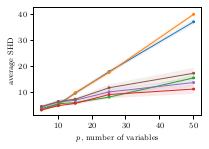

In [154]:
plt.figure(figsize = (3.0, 2.0))
plt.xlabel("$p$, number of variables")
plt.ylabel("average empirical risk " + r"$R_{\mathrm{emp}}(W)$")
# plt.ylabel("average true risk " + r"$R(W)$")
plt.ylabel("average SHD$")
def plot_results(method, metric, results, method_name, linestyle = '-'):
    # plot mean and standard error of DAG-OMP as a function of p.
    plt.plot(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) for i in range(5)], marker = 'o', markersize = 2, linewidth = 1, label = method_name, linestyle = linestyle)
    plt.fill_between(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) - sem(results[method][metric][10*i:10*i + 10])for i in range(5)], [np.mean(results[method][metric][10*i:10*i + 10]) + sem(results[method][metric][10*i:10*i + 10])for i in range(5)], alpha = 0.1)

metric = "shd"

plot_results("rw_2", metric, results, "Random Walk")
plot_results("mcmc_r", metric, results, "MH-R")
plot_results("mcmc_g", metric, results, "MH-G")

plot_results("notears", metric, results, "NO TEARS")
plot_results("dagomp", metric, results, "DAG-OMP")
plot_results("dagols", metric, results, "DAG-OLS-V")

# plot_results("daglasso", metric, results, "DAG-LASSO")
# plt.legend(ncol = 6, loc = 'upper left', bbox_to_anchor=(-0.08, 1.2), columnspacing = 0.75, handletextpad = 0.25)
plt.savefig("cyclicT1000shd.pgf", bbox_inches = 'tight')

In [138]:
from datetime import datetime 

a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}datamatricesT100cyclic.pkl", "wb")
pickle.dump(datasets, a_file)
a_file.close()

In [150]:
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}resultsT1000cyclic.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [135]:
print(results)

{'exh': {'mse': [], 'emse': [], 'shd': []}, 'rw_1': {'mse': [15.51930938321329, 14.924349291129303, 13.660942854655335], 'emse': [17.516740093308872, 15.401844761611144, 14.704537659885943], 'shd': [8, 5, 7]}, 'rw_2': {'mse': [13.999709388260959, 12.228860513658205, 11.009037499064128], 'emse': [16.00566941217162, 12.829642876442566, 11.46746177572549], 'shd': [8, 5, 3]}, 'mcmc_r': {'mse': [12.024503788670984, 13.31533144689828, 11.482735353102102], 'emse': [13.335378788807015, 13.635525214870079, 11.938330731617661], 'shd': [3, 6, 4]}, 'mcmc_t': {'mse': [13.613771055732878, 13.922145699454504, 13.337233489153268], 'emse': [18.70094473651455, 14.918398467202367, 14.102116452002623], 'shd': [8, 9, 6]}, 'mcmc_s': {'mse': [15.12822142217938, 12.884178708481915, 13.69909986030214], 'emse': [17.585350786235104, 14.172125584287423, 13.930770954147391], 'shd': [9, 5, 4]}, 'mcmc_g': {'mse': [15.401595274960952, 11.349025040383523, 10.744590216335688], 'emse': [16.325961093178222, 12.0083041498

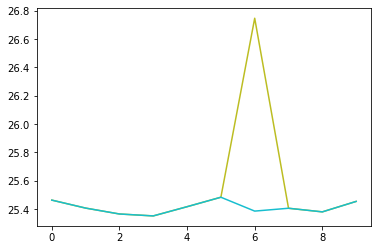

In [160]:
for method in results:
    for metric in results[method]:
        if metric == "emse" and method != "daglasso":
            plt.plot(results[method][metric])

In [74]:
import statsmodels.api as sm
import scipy.linalg as slin

def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()

    np.fill_diagonal(W2, np.zeros(np.shape(W)[0]))

    E = slin.expm(W2)  # (Zheng et al. 2018)
    h = np.trace(E) - p

    return h
    
def get_all_violating_edges(W, epsilon = 1e-16):
   
    h_val = _h(W)
    
    violators = set()
    
    for i in range(p):
        for j in range(p):
            if W[i][j] != 0:
                # remove Wij
                tmp = W[i][j]
                W[i][j] = 0
            
                # check h
                h_diff = h_val - _h(W)
            
                # check change
                if np.abs(h_diff) > epsilon:
                    violators.add((i, j))
            
                # add Wij back
                W[i][j] = tmp

    return violators

def B_V_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    def OLS(X):
        # get regressor and variables
        y = X[1:]
        x = X[:-1]

        # initialize W_hat
        W_hat = np.array([])

        # get parameters
        for i in range(p):
            est = sm.OLS(y[:, i], x).fit()
            W_hat = np.append(W_hat, est.params)

        # return W
        return W_hat.reshape((p, p)).T
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):       
        if np.sum(W != 0) % 500 == 0: print(np.sum(W != 0))
        # get all violating edges
        violators = get_all_violating_edges(W)
        
        # find edge with smallest coefficient
        smallest_coef = np.min([np.abs(W[row][col]) for row, col in violators])
        row, col = np.where(np.abs(W) == smallest_coef)
        row, col = row[0], col[0]
    
        # set this edge to zero
        W[row][col] = 0
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
        # add edge and score to list
        # order_of_importance.append([row, col])
        # scores.append(h.MSE(W, X))
    
    # we have a dag, return this one for now
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
#     while len(np.nonzero(W)[0]) > 0:   
        
#         # set zero values to impossible value
#         W[W == 0] = 1e10
        
#         # get smallest nonzero coefficient in absolute value
#         row, col = np.argmin(np.abs(W)) // p, np.argmin(np.abs(W)) % p
        
#         # set this to zero
#         W[row][col] = 0
        
#         # revert the zero values back to zero
#         W[W == 1e10] = 0

#         edge = [row, col]
        
#         # update column
#         idx = np.nonzero(W[:, col])[0]
#         W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
#         score = h.MSE(W, X)
        
#         if score < tol: 
#             break
            
#         order_of_importance.append(edge)
#         scores.append(h.MSE(W, X))
        
    # return the DAG W
    return W_return # , order_of_importance, scores

W_B_V_LINGNAM_OLS = B_V_LINGNAM_OLS(X)
# print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
# print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")
print(W_B_V_LINGNAM_OLS)
plt.figure(figsize = (12, 4))
plt.plot(np.flip(scores))

2500


KeyboardInterrupt: 

In [115]:
def in_cycle(W, i, j, epsilon = 1e-32):
    
    h_val = _h(W)
    
    w_tmp = W[i][j]
    W[i][j] = 0
    h_new = _h(W)
    W[i][j] = w_tmp
    
    return np.abs(h_val - h_new) > epsilon

def B_V_LINGNAM_OLS_Q(X, tol = 0.0):
    """OLS solution W, data X"""
    
    def OLS(X):
        # get regressor and variables
        y = X[1:]
        x = X[:-1]

        # initialize W_hat
        W_hat = np.array([])

        # get parameters
        for i in range(p):
            est = sm.OLS(y[:, i], x).fit()
            W_hat = np.append(W_hat, est.params)

        # return W
        return W_hat.reshape((p, p)).T
    
    T, p = np.shape(X)
    
    # get full OLS solution of W
    W = OLS(X)
    
    # non_violators
    violators = np.ones((p, p))
    
    # while we still do not have a DAG
    while not h.is_dag(W):     
        if np.sum(W != 0) % 250 == 0: print(np.sum(W != 0))
        # print(h.is_dag(W))
        
        # find edge with smallest coefficient which might be a violator
        i_list, j_list = np.where((np.abs(W) == np.min(np.abs(W[(W * violators).nonzero()]))))
        i, j = i_list[0], j_list[0]
        
        # if it is contained in a cycle, remove it
        # if not, never consider it again
        if in_cycle(W, i, j):
            W[i][j] = 0
            violators[i][j] = 0
        
            # update column
            idx = np.nonzero(W[:, j])[0]
            W[idx, j] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, j])
        else:
            violators[i][j] = 0
  
    # return the DAG W
    return W

W, X = datasets[1][0]
W_q = B_V_LINGNAM_OLS_Q(X)

In [104]:
print(np.sum(W != 0))

217
